# Wavefield Frequency Domain Analysis

This notebook demonstrates how to compute and visualize the frequency domain representation of a wavefield using the Fast Fourier Transform (FFT).

In [1]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from examples.seismic import demo_model, plot_velocity, plot_perturbation
from examples.seismic import AcquisitionGeometry
from examples.seismic.acoustic import AcousticWaveSolver
from wavefield_fft import plot_wavefield_fft, plot_wavefield_fft_snapshots

## 1. Set up the model and geometry

Operator `initdamp` ran in 0.01 s


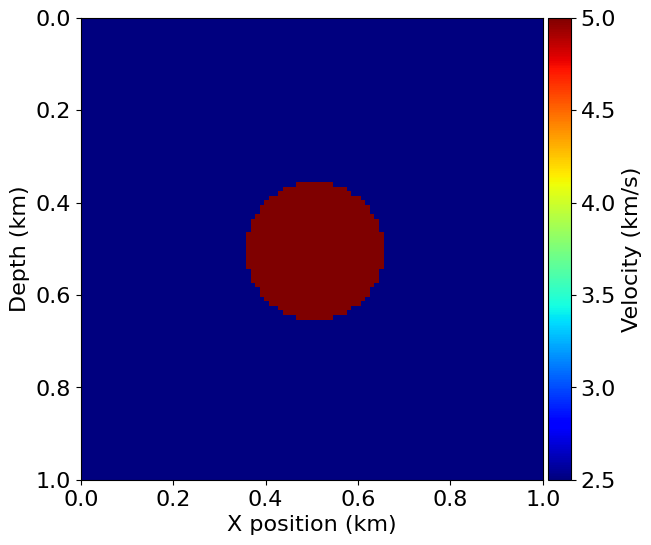

In [2]:
# Define model parameters
shape = (101, 101)  # Number of grid points (nx, nz)
spacing = (10., 10.)  # Grid spacing in m. The domain size is now 1km by 1km
origin = (0., 0.)  # Need origin to define relative source and receiver locations

# Create the model with a circular perturbation
model = demo_model('circle-isotropic', vp_circle=5.0, vp_background=2.5,
                    origin=origin, shape=shape, spacing=spacing, nbl=40, radio_custom=10)

# Plot the velocity model
plot_velocity(model)

In [3]:
# Define source and receivers
t0 = 0.
tn = 1000. 
f0 = 0.01  # 10Hz

# Source at the center of the top edge
src_coordinates = np.empty((1, 2))
src_coordinates[0, :] = np.array(model.domain_size) * .5
src_coordinates[0, 0] = 20.  # Depth is 20m
 
# Receivers along the top edge
nreceivers = 101  # Number of receiver locations per shot 
rec_coordinates = np.empty((nreceivers, 2))
rec_coordinates[:, 1] = np.linspace(0, model.domain_size[0], num=nreceivers)
rec_coordinates[:, 0] = 0.

# Create the geometry object
geometry = AcquisitionGeometry(model, rec_coordinates, src_coordinates, t0, tn, f0=f0, src_type='Ricker')

## 2. Run the forward simulation to get the wavefield

In [4]:
# Create the solver
solver = AcousticWaveSolver(model, geometry, space_order=4)

# Run the forward simulation and save the wavefield
true_d, u, _ = solver.forward(vp=model.vp, save=True)

# u contains the wavefield at all time steps
print(f"Wavefield shape: {u.data.shape}")

Operator `Forward` ran in 0.03 s


Wavefield shape: (818, 181, 181)


## 3. Visualize the wavefield in time domain

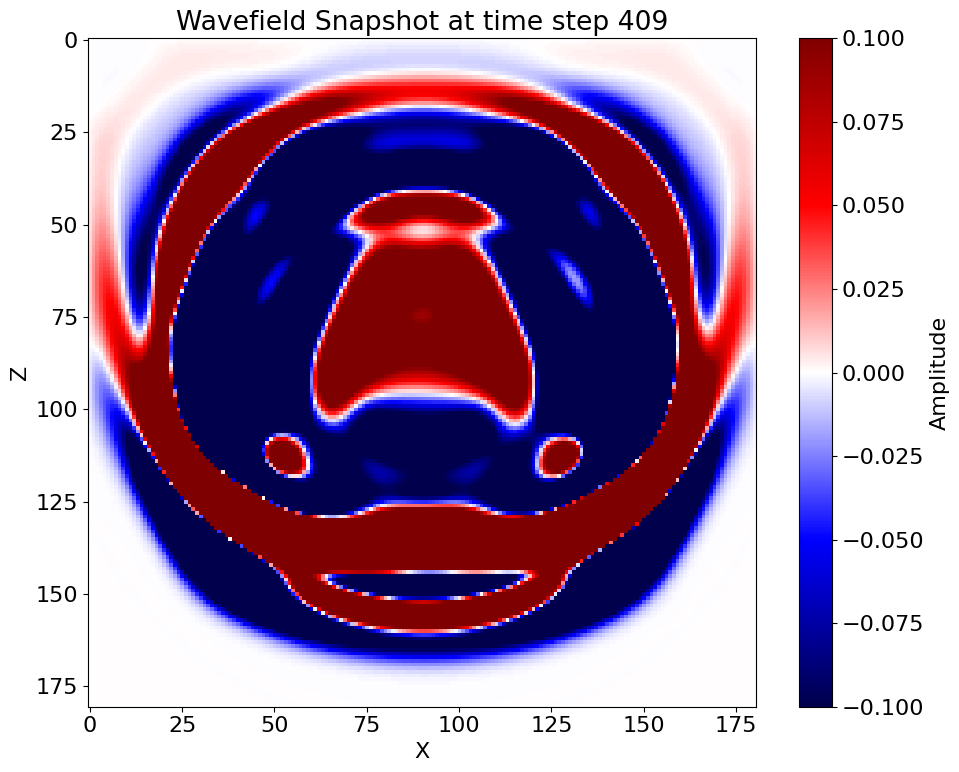

In [6]:
# Plot a snapshot of the wavefield at a specific time
time_index = u.data.shape[0] // 2  # Middle time step
plt.figure(figsize=(10, 8))
plt.imshow(u.data[time_index], cmap='seismic', vmin=-0.1, vmax=0.1)
plt.colorbar(label='Amplitude')
plt.title(f'Wavefield Snapshot at time step {time_index}')
plt.xlabel('X')
plt.ylabel('Z')
plt.tight_layout()

## 4. Compute and visualize the frequency domain representation

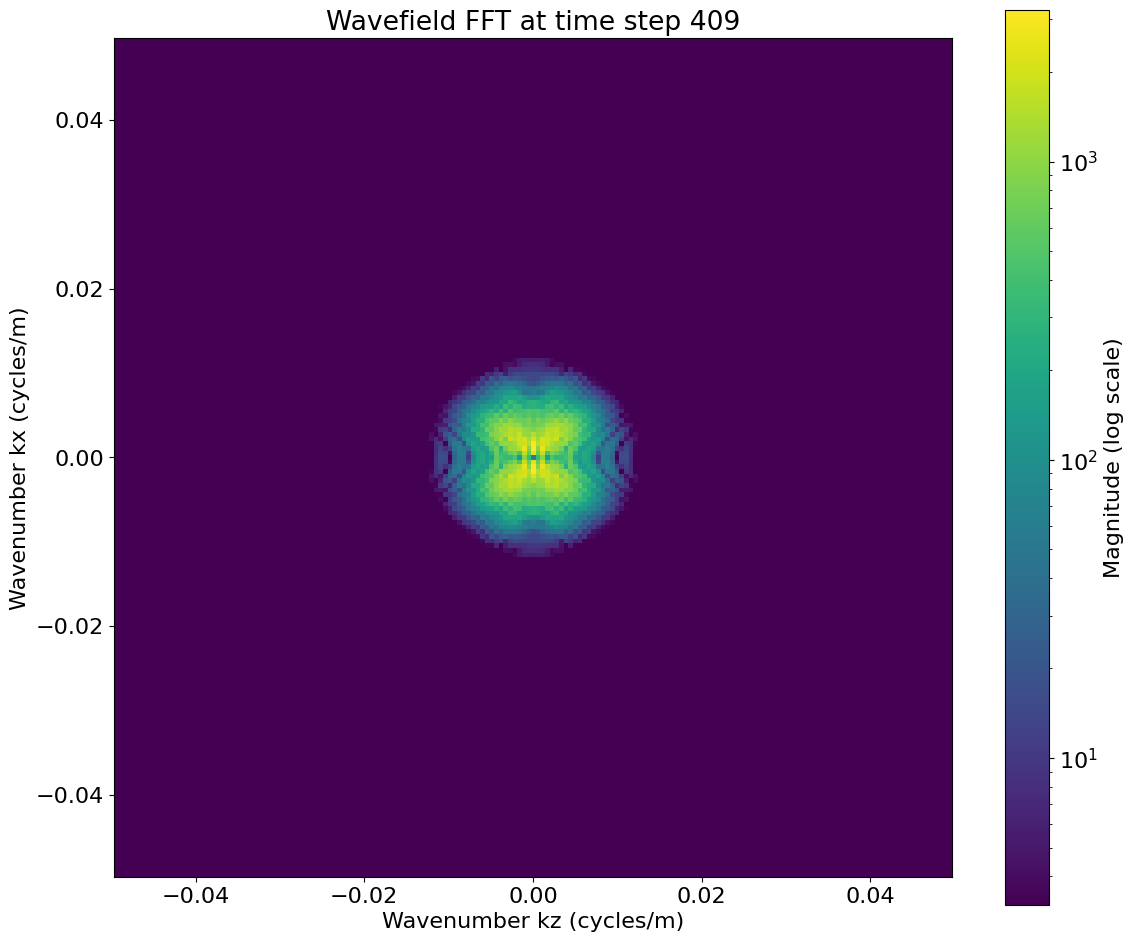

In [7]:
# Plot the frequency domain representation of a single snapshot
time_index = u.data.shape[0] // 2  # Middle time step
fig = plot_wavefield_fft(u.data[time_index], model, title=f"Wavefield FFT at time step {time_index}")

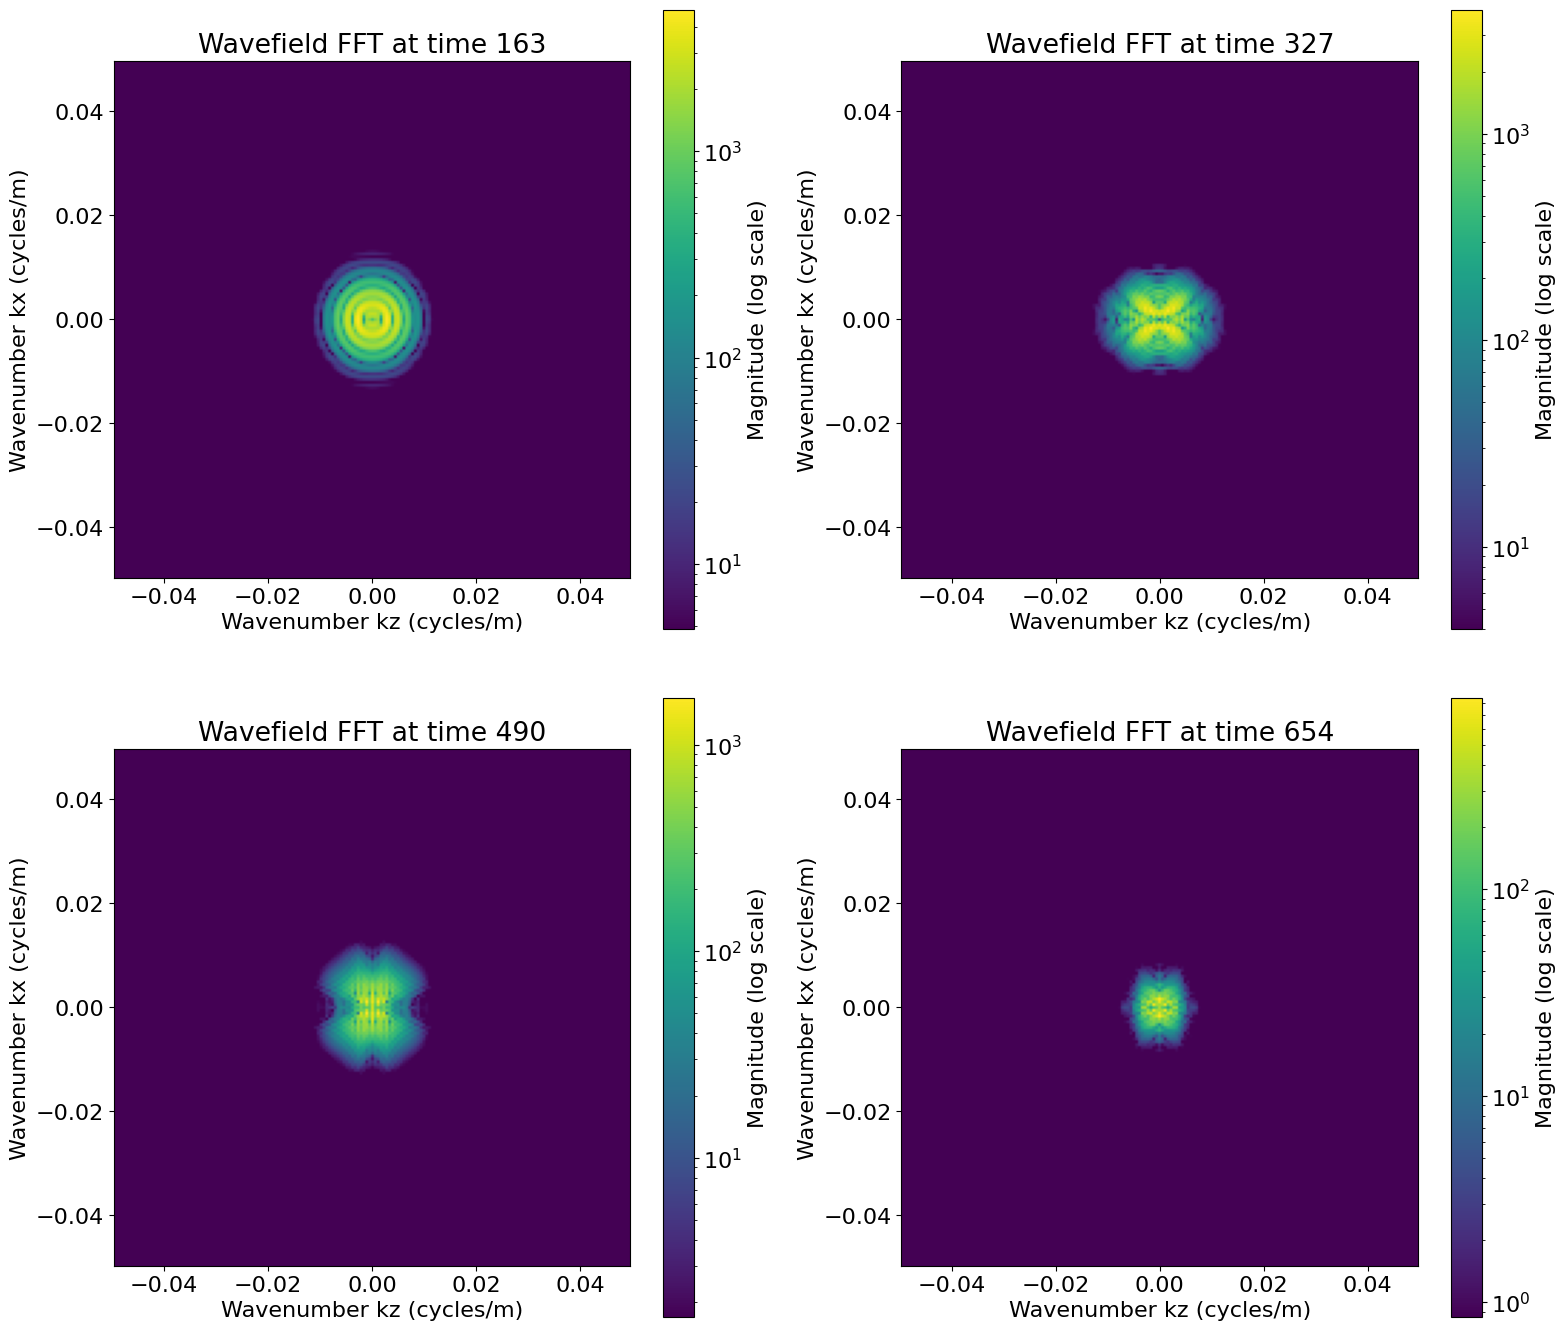

In [8]:
# Plot the frequency domain representation at multiple time steps
fig = plot_wavefield_fft_snapshots(u.data, model)

## 5. Analyze the full wavefield in frequency domain

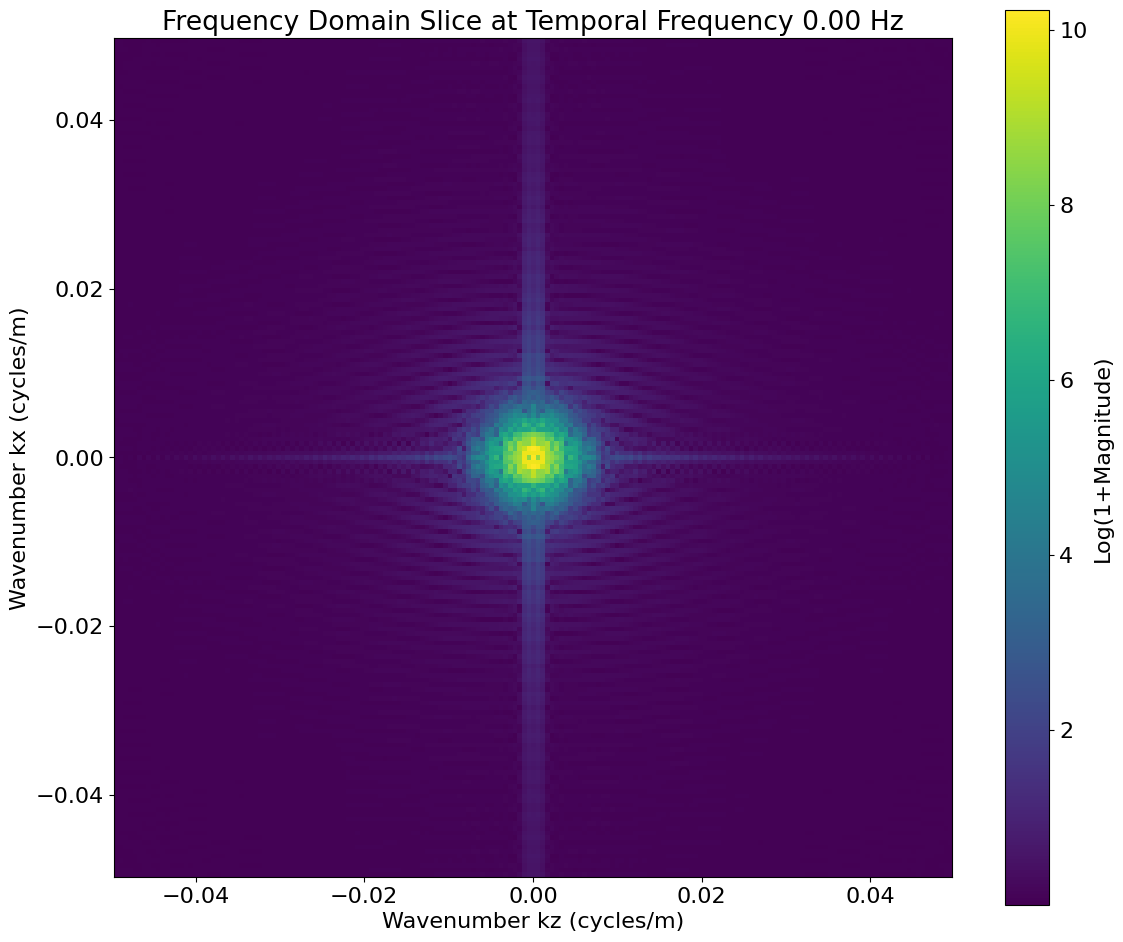

In [9]:
# Compute the 3D FFT of the entire wavefield (time, x, z)
from scipy.fftpack import fftn, fftshift

# Get the wavefield data
wavefield_data = u.data

# Compute the 3D FFT
fft_3d = fftn(wavefield_data)
fft_3d_shifted = fftshift(fft_3d)
magnitude_3d = np.abs(fft_3d_shifted)

# Create the frequency axes
nt, nx, nz = wavefield_data.shape
dt = (tn - t0) / nt  # Time step
dx, dz = model.spacing

# Frequency axes
freq_t = np.fft.fftshift(np.fft.fftfreq(nt, dt))  # Temporal frequency in Hz
freq_x = np.fft.fftshift(np.fft.fftfreq(nx, dx))  # Spatial frequency in cycles/m
freq_z = np.fft.fftshift(np.fft.fftfreq(nz, dz))  # Spatial frequency in cycles/m

# Plot a slice at the middle temporal frequency
middle_freq_idx = nt // 2
plt.figure(figsize=(12, 10))
plt.imshow(np.log1p(magnitude_3d[middle_freq_idx]), cmap='viridis',
           extent=[freq_z.min(), freq_z.max(), freq_x.min(), freq_x.max()])
plt.colorbar(label='Log(1+Magnitude)')
plt.title(f'Frequency Domain Slice at Temporal Frequency {freq_t[middle_freq_idx]:.2f} Hz')
plt.xlabel('Wavenumber kz (cycles/m)')
plt.ylabel('Wavenumber kx (cycles/m)')
plt.tight_layout()

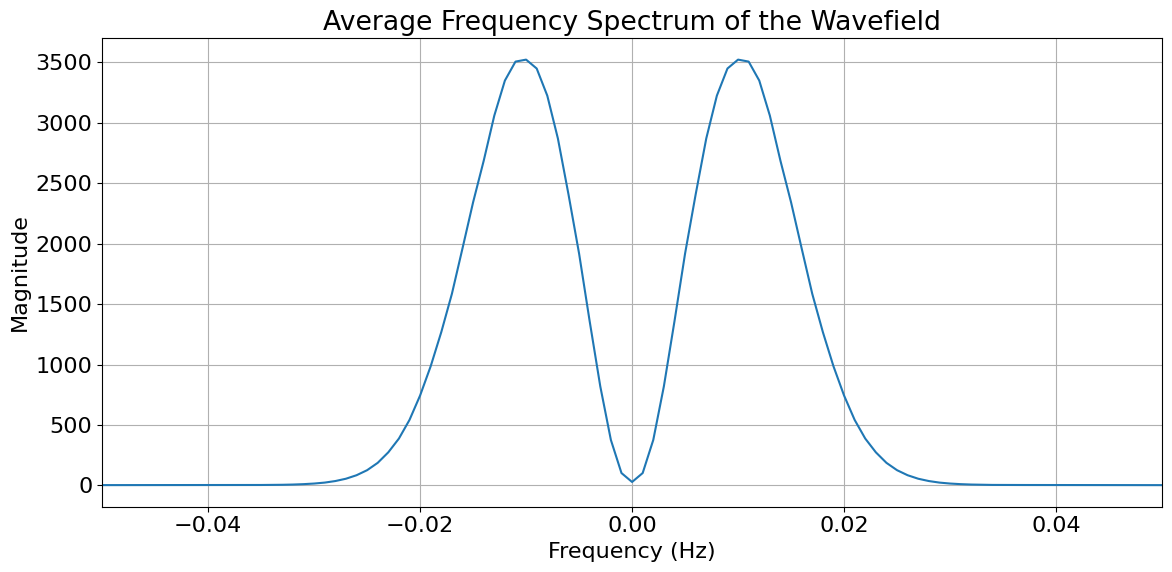

In [10]:
# Plot the frequency spectrum along the time axis (averaged over space)
avg_spectrum = np.mean(magnitude_3d, axis=(1, 2))

plt.figure(figsize=(12, 6))
plt.plot(freq_t, avg_spectrum)
plt.grid(True)
plt.title('Average Frequency Spectrum of the Wavefield')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.xlim(-0.05, 0.05)  # Focus on the relevant frequency range
plt.tight_layout()

## 6. Visualize the wavefield in frequency-wavenumber domain

In [11]:
# Create a function to plot frequency-wavenumber (f-k) diagram
def plot_fk_diagram(wavefield, dt, dx):
    """
    Plot the frequency-wavenumber diagram for a 2D wavefield (time, space).
    
    Parameters:
    -----------
    wavefield : numpy.ndarray
        The wavefield data with shape (time, space)
    dt : float
        Time sampling interval
    dx : float
        Space sampling interval
    """
    # Compute the 2D FFT
    fk = np.fft.fft2(wavefield)
    fk_shifted = np.fft.fftshift(fk)
    magnitude = np.abs(fk_shifted)
    
    # Create the frequency and wavenumber axes
    nt, nx = wavefield.shape
    f = np.fft.fftshift(np.fft.fftfreq(nt, dt))  # Frequency in Hz
    k = np.fft.fftshift(np.fft.fftfreq(nx, dx))  # Wavenumber in cycles/m
    
    # Plot
    plt.figure(figsize=(10, 8))
    plt.imshow(np.log1p(magnitude), cmap='viridis', 
               extent=[k.min(), k.max(), f.min(), f.max()],
               aspect='auto')
    plt.colorbar(label='Log(1+Magnitude)')
    plt.title('Frequency-Wavenumber (f-k) Diagram')
    plt.xlabel('Wavenumber (cycles/m)')
    plt.ylabel('Frequency (Hz)')
    plt.tight_layout()
    
    return plt.gcf()

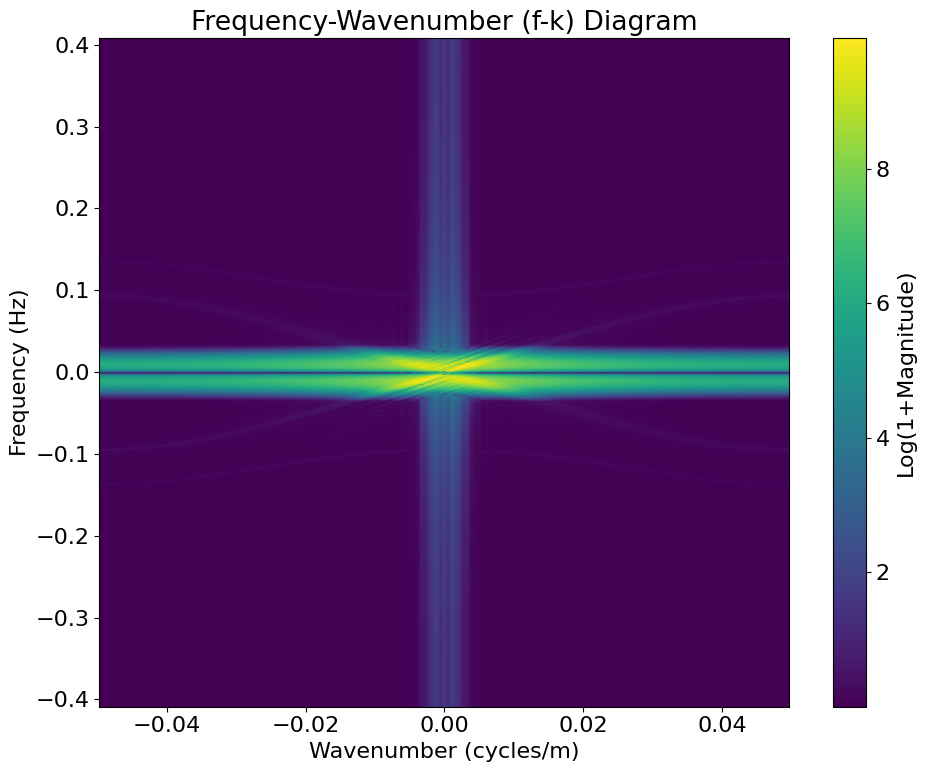

In [12]:
# Extract a 2D slice of the wavefield (time, x) at a fixed depth
middle_z = wavefield_data.shape[2] // 2
wavefield_slice = wavefield_data[:, :, middle_z]

# Calculate dt
dt = (tn - t0) / wavefield_data.shape[0]

# Plot the f-k diagram
fig = plot_fk_diagram(wavefield_slice, dt, model.spacing[0])

## 7. Analyze the recorded data in frequency domain

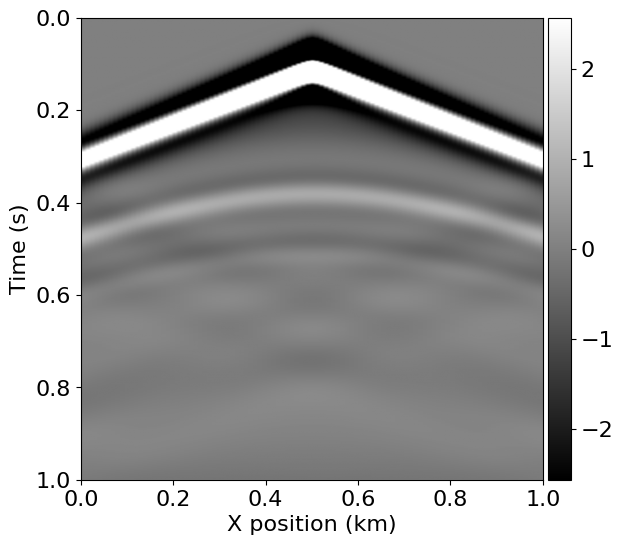

In [13]:
# Plot the shot record
from examples.seismic import plot_shotrecord
plot_shotrecord(true_d.data, model, t0, tn)

In [14]:
# Plot the f-k diagram of the recorded data
fig = plot_fk_diagram(true_d.data[0], dt, model.spacing[0])

IndexError: index -2 is out of bounds for axis 0 with size 1

## 8. Conclusion

In this notebook, we've demonstrated how to:

1. Compute the frequency domain representation of a wavefield using FFT
2. Visualize the wavefield in both time and frequency domains
3. Analyze the frequency content of the wavefield
4. Create frequency-wavenumber (f-k) diagrams

These techniques are useful for understanding the spectral characteristics of wavefields and can be applied to various seismic processing and analysis tasks.